In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [114]:
df=pd.read_csv("ds_train.csv")
df=df.drop(["PassengerId","Ticket",],axis=1)                
df.insert(5,"FamSize",(df.Parch+df.SibSp),True)             
#Add relatives together in a column to get the family size
df=df.rename(columns={"Parch":"ParCh"})                     
df["Survived"]=df["Survived"].replace({"yes":1,"no":0})
df["Age"].fillna(value=df["Age"].ffill(),inplace=True)

In [115]:
#Age and Embarked are missing calues, but we can fill them. Cabin is missing a lot, so we can not extrapolate based on existing data
df["Age"].fillna(value=df["Age"].mean(),inplace=True)
df['Embarked'].fillna(df["Embarked"].mode()[0],inplace=True)

In [116]:
#Create a function to extract the deck code from the cabin number, X for NaN
def deck(cabin_no):
    deck_no="X"
    if not pd.isna(cabin_no):
        deck_no=re.search(r"([A-Za-z]+)",str(cabin_no)).group(0)
    return deck_no

In [117]:
#Put the results from the function in a new column
df["Deck"]=df["Cabin"].map(lambda x: deck(x))
df.drop(columns=["Cabin"],inplace=True)
df["Deck"]=df["Deck"].replace("T","B")
#Replace deck T as it was storage. Judging by fare, class and frequency, we will replace it with deck B
#No missing values in the dataset

In [118]:
#Function to get name titles 
def title_gen(namen):
    title = re.search(r"(,[A-Za-z ]+\.?)", namen).group(0).replace(", ","")
    return title

df["Title"]=df["Name"].map(lambda x: title_gen(x))

In [119]:
#Function to extract the title from the name and sort them based on sex and social ranking
def title_mod(i):
    title=i["Title"]
    if title in ['Don.', 'Major.', 'Lady.', 'Sir.', 'Col.', 'Capt.',
       'the Countess.', 'Jonkheer.']:
        if i["Sex"]=="female":
            return "Noblewoman"
        else:
            return "Nobleman"
    elif title in ['Dr.','Mrs.', 'Miss.','Mme.','Ms.','Mlle.'] and i["Sex"]=="female":
        return "Mrs"
    else:
        return "Mr"

df["Title"]=df.apply(lambda x: title_mod(x), axis=1)
#We have created a column with each passenger's title, so we can drop the name column
df.drop(columns=["Name"],inplace=True)

In [120]:
#Find mortality numbers and rate for children divided by class
temp_list=np.zeros((3,4))
for i in range(0,3):
    temp=df.loc[(df.Age<18) & (df.Pclass==i+1)]["Survived"]
    temp_list[i,0]=temp.sum()
    temp_list[i,1]=len(temp)
    temp_list[i,2]=temp_list[i,1]-temp_list[i,0]
    temp_list[i,3]=temp_list[i,0]/temp_list[i,1]
child=pd.DataFrame(temp_list)
temp={0:"1",1:"2",2:"3"}
child=child.rename(index=temp)
child.index.names=["Class"]
temp={0:"Survived",1:"Total",2:"Dead",3:"Surv.Rate"}
child=child.rename(columns=temp)

In [121]:
#Find mortality numbers and rate for adults divided by class
temp_list=np.zeros((3,4))
for i in range(0,3):
    temp=df.loc[(df.Age>=18) & (df.Sex=="male") & (df.Pclass==i+1)]["Survived"]
    temp_list[i,0]=temp.sum()
    temp_list[i,1]=len(temp)
    temp_list[i,2]=temp_list[i,1]-temp_list[i,0]
    temp_list[i,3]=temp_list[i,0]/temp_list[i,1]
male_vict=pd.DataFrame(temp_list)
temp={0:"1",1:"2",2:"3"}
male_vict=male_vict.rename(index=temp)
male_vict.index.names=["Class"]
temp={0:"Survived",1:"Total",2:"Dead",3:"Surv.Rate"}
male_vict=male_vict.rename(columns=temp)

In [122]:
temp_list=np.zeros((3,4))
for i in range(0,3):
    temp=df.loc[(df.Age>=18) & (df.Sex=="female") & (df.Pclass==i+1)]["Survived"]
    temp_list[i,0]=temp.sum()
    temp_list[i,1]=len(temp)
    temp_list[i,2]=temp_list[i,1]-temp_list[i,0]
    temp_list[i,3]=temp_list[i,0]/temp_list[i,1]
fem_vict=pd.DataFrame(temp_list)
temp={0:"1",1:"2",2:"3"}
fem_vict=fem_vict.rename(index=temp)
fem_vict.index.names=["Class"]
temp={0:"Survived",1:"Total",2:"Dead",3:"Surv.Rate"}
fem_vict=fem_vict.rename(columns=temp)

In [123]:
print(male_vict,fem_vict,child)
#Almost all women survived, especially in 1st and 2nd class, half of them in 3rd class
#Majority of children survived, especially in 1st and 2nd class, and about 40% in 3rd class

       Survived  Total   Dead  Surv.Rate
Class                                   
1          40.0  114.0   74.0   0.350877
2           7.0   94.0   87.0   0.074468
3          33.0  289.0  256.0   0.114187        Survived  Total  Dead  Surv.Rate
Class                                  
1          80.0   82.0   2.0    0.97561
2          58.0   64.0   6.0    0.90625
3          50.0  105.0  55.0    0.47619        Survived  Total  Dead  Surv.Rate
Class                                  
1          16.0   20.0   4.0   0.800000
2          22.0   26.0   4.0   0.846154
3          36.0   97.0  61.0   0.371134


In [124]:
fam_surv=df[["FamSize","Survived"]]
fam_surv.groupby(by="FamSize").mean()
#Most of the survivors seems to have a family size of 1-3 persons
#Single passengers and larger families has higher mortality rates

,Survived
FamSize,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [125]:
temp=df[["Deck","Survived"]]
print(temp.groupby(by="Deck").mean())
#Passengers at decks B, D and E had a higher survival rate, followed by decks C and F
#Decks G and A had ~50% survival rate, while passengers of unknown decks were more likely to perish

      Survived
Deck          
A     0.466667
B     0.729167
C     0.593220
D     0.757576
E     0.750000
F     0.615385
G     0.500000
X     0.299854


In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
df["Sex"]=df["Sex"].replace("male",0)
df["Sex"]=df["Sex"].replace("female",1)


In [127]:
x=df.drop(["Survived","Embarked","Deck","Title"],axis=1)
y=df["Survived"]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)
xtrain_norm=xtrain
xtest_norm=xtest

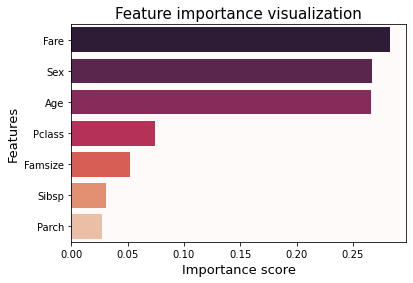

In [128]:
temp=RandomForestClassifier(n_estimators=100)
temp.fit(xtrain,ytrain)
feature_imp=pd.Series(temp.feature_importances_,index=x.columns[:]).sort_values(ascending=False)
feature_imp.index=feature_imp.index.str.replace("_"," ")
feature_imp.index=feature_imp.index.str.capitalize()
sns.barplot(x=feature_imp,y=feature_imp.index,palette="rocket",color="snow").set_facecolor(color="snow")
plt.xlabel("Importance score",fontsize=13)
plt.ylabel("Features",fontsize=13)
plt.title("Feature importance visualization",fontsize=15)
plt.show()

0.8100558659217877
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       105
           1       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



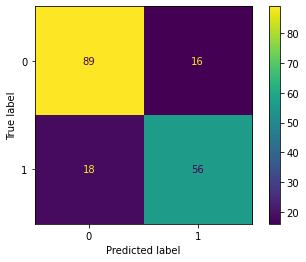

In [129]:
strap=False
depth=60
features=0.3
samples_leaf=2
samples_split=2
estimators=600
oob=False
rf=RandomForestClassifier(n_estimators=estimators,max_depth=depth,max_features=features,
min_samples_leaf=samples_leaf,min_samples_split=samples_split,bootstrap=strap,oob_score=oob,n_jobs=-1)
rf.fit(xtrain_norm,ytrain)
pred_rf=rf.predict(xtest_norm)
a_rf=accuracy_score(ytest,pred_rf)
print(a_rf)
print(classification_report(ytest,pred_rf))
plot_confusion_matrix(rf,xtest,ytest)
plt.show()